In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

#data load

In [3]:
filename = '/content/drive/MyDrive/train_df.csv'
filename2 = '/content/drive/MyDrive/sample_submission.csv'

In [4]:
train = pd.read_csv(filename)
submission = pd.read_csv(filename2)

In [5]:
train.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.48423,1020.117796,338.890539,1048.000000,343.000000,992.0,394.0,1054.0,400.0,956.0,368.0,1134.0,371.0,1003.497242,327.640085,1078.0,341.0,999.0,570.0,1046.0,573.0,995.0,695.0,1054.0,698.0,983.000000,820.000000,1042.0,829.0,1019.107277,373.766222,1013.137360,316.311695,1067.00000,335.0,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.59369,1041.422997,331.694815,1065.593682,333.968459,1010.0,398.0,1077.0,386.0,974.0,398.0,1144.0,337.0,1004.000000,346.000000,1094.0,326.0,1020.0,557.0,1069.0,567.0,1013.0,583.0,1072.0,697.0,1003.843781,678.797029,1042.0,829.0,1047.279440,362.031898,1017.383112,332.890539,1081.18738,323.0,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445


In [6]:
train.shape

(4195, 49)

In [7]:
submission.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,649-2-4-32-Z148_A-0000003.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
submission.shape

(1600, 49)

##img 경로 불러오기

In [11]:
train.image.values

array(['001-1-1-01-Z17_A-0000001.jpg', '001-1-1-01-Z17_A-0000003.jpg',
       '001-1-1-01-Z17_A-0000005.jpg', ...,
       '642-2-4-31-Z148_E-0000027.jpg', '642-2-4-31-Z148_E-0000029.jpg',
       '642-2-4-31-Z148_E-0000031.jpg'], dtype=object)

In [12]:
# train_paths = glob.glob("/content/drive/My Drive/1. open/train_imgs/*.jpg")
# google colab에서는 "train_imgs" 폴더 안의 순서가 뒤엉킴

train_paths = []

for i in range(len(train)):
    val = train.image.values[i]
    image_path = f"/content/drive/MyDrive/train_imgs/{val}"
    train_paths.append(image_path)

len(train_paths)

4195

In [13]:
#glob를 활용해 이미지의 경로들을 불러옵니다.

import glob
# train_paths = glob.glob('/content/drive/MyDrive/train_imgs/*.jpg')
test_paths = glob.glob('/content/drive/MyDrive/test_imgs/*.jpg')
print(len(train_paths), len(test_paths))

4195 1600


In [14]:
test_paths[:3]

['/content/drive/MyDrive/test_imgs/714-3-5-35-Z94_D-0000015.jpg',
 '/content/drive/MyDrive/test_imgs/714-3-5-35-Z94_D-0000013.jpg',
 '/content/drive/MyDrive/test_imgs/714-3-5-35-Z94_C-0000031.jpg']

In [15]:
train_paths[:3]

['/content/drive/MyDrive/train_imgs/001-1-1-01-Z17_A-0000001.jpg',
 '/content/drive/MyDrive/train_imgs/001-1-1-01-Z17_A-0000003.jpg',
 '/content/drive/MyDrive/train_imgs/001-1-1-01-Z17_A-0000005.jpg']

#시각화

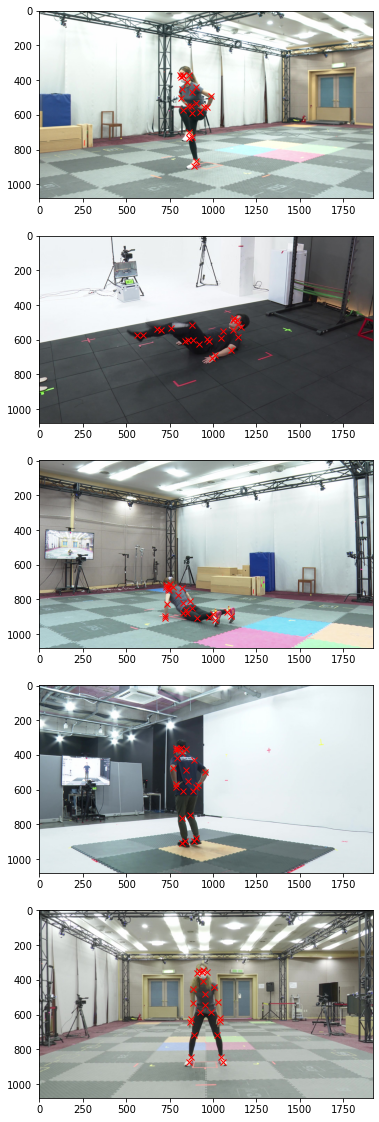

In [16]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

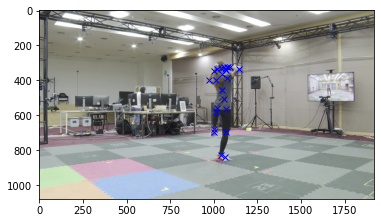

In [17]:
keypoint = train.iloc[:, 1:49]
keypoint_sample = keypoint.iloc[1,:] # train의 첫 번째 이미지 keypoint

img_sample_path = train_paths[1]
img = Image.open(img_sample_path)
img_np = np.array(img) # train의 첫 번째 이미지 

for j in range(0, len(keypoint.columns),2):
  plt.plot(keypoint_sample[j], keypoint_sample[j+1], 'bx')
  plt.imshow(img_np)

#model

In [18]:
train['path'] = train_paths

In [19]:
train.head(3)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y,path
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,343.000000,992.0,394.0,1054.0,400.0,956.0,368.0,1134.0,371.0,1003.497242,327.640085,1078.0,341.0,999.0,570.0,1046.0,573.0,995.0,695.0,1054.0,698.0,983.000000,820.000000,1042.0,829.0,1019.107277,373.766222,1013.137360,316.311695,1067.00000,335.0,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465,/content/drive/MyDrive/train_imgs/001-1-1-01-Z...
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,333.968459,1010.0,398.0,1077.0,386.0,974.0,398.0,1144.0,337.0,1004.000000,346.000000,1094.0,326.0,1020.0,557.0,1069.0,567.0,1013.0,583.0,1072.0,697.0,1003.843781,678.797029,1042.0,829.0,1047.279440,362.031898,1017.383112,332.890539,1081.18738,323.0,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445,/content/drive/MyDrive/train_imgs/001-1-1-01-Z...
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,334.109461,1020.0,381.0,1083.0,389.0,984.0,362.0,1163.0,372.0,1027.507419,327.383120,1111.0,340.0,1016.0,552.0,1061.0,556.0,1018.0,674.0,1070.0,696.0,987.703151,788.867342,1044.0,826.0,1063.029716,358.679953,1042.374777,319.031541,1101.00000,334.0,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554,/content/drive/MyDrive/train_imgs/001-1-1-01-Z...


In [20]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [180,320]) # 이미지 resize 
        target = train.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        
        yield (img, target)


In [21]:
#generator를 활용해 데이터셋 만들기        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([180,320,3]),tf.TensorShape([48])))


In [22]:
train_dataset

<FlatMapDataset shapes: ((180, 320, 3), (48,)), types: (tf.float32, tf.float32)>

In [23]:
train_dataset = train_dataset.batch(32).prefetch(1)

In [24]:
train_dataset

<PrefetchDataset shapes: ((None, 180, 320, 3), (None, 48)), types: (tf.float32, tf.float32)>

In [25]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D


In [26]:
#간단한 CNN 모델을 적용합니다.

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(48))

In [27]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

## model 적합

In [35]:
model.fit(train_dataset, epochs = 3, verbose = 1)

Epoch 1/3
132/132 [==============================] - 1777s 13s/step - loss: 82734.6532 - mae: 188.0982
Epoch 2/3
132/132 [==============================] - 1757s 13s/step - loss: 14737.6367 - mae: 92.0524
Epoch 3/3
132/132 [==============================] - 1747s 13s/step - loss: 18068.3674 - mae: 101.1133


##test data

In [28]:
X_test = []
for test_path in tqdm(test_paths):
  img = tf.io.read_file(test_path)
  img = tf.image.decode_jpeg(img, channels = 3)
  img = tf.image.resize(img, [180,320])
  X_test.append(img)

100%|██████████| 1600/1600 [06:43<00:00,  3.96it/s]


In [29]:
type(X_test)

list

In [30]:
X_test[0].shape

TensorShape([180, 320, 3])

In [31]:
X_test2 = tf.stack(X_test, axis = 0) # X_test를 tensor화 시키기

In [32]:
len(X_test2)

1600

In [33]:
len(X_test)

1600

In [34]:
X_test2.shape  # x_test = tensor

TensorShape([1600, 180, 320, 3])

In [36]:
pred = model.predict(X_test2)

# submission

In [37]:
submission.iloc[:,1:] = pred
submission.to_csv('baseline_submission.csv', index = False)

In [38]:
submission

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,1072.382080,340.632141,1076.584229,416.654358,1115.218506,392.055664,1125.603149,413.428589,1110.262207,519.353271,1082.540039,610.532349,1062.804321,513.719238,1049.040405,408.777893,1006.041687,526.432312,1099.075073,435.497650,1019.372742,399.808380,1100.509399,703.607727,1062.412231,691.486084,1125.795776,748.766479,1061.355103,763.266235,1049.272827,732.512573,946.501831,788.197571,1041.213745,380.444519,1022.602051,151.092834,947.353638,247.123520,1026.503662,463.748077,1018.582520,579.376221,1055.469727,618.349426,1036.694824,705.382751
1,649-2-4-32-Z148_A-0000003.jpg,1083.759277,354.345245,1090.334717,434.625793,1128.603516,413.821899,1143.382568,433.775940,1128.114868,539.312378,1096.427490,626.821045,1076.630249,530.029663,1061.989868,422.510498,1022.836853,542.792053,1114.798218,449.824738,1038.763794,414.980743,1118.690063,720.968567,1077.524536,701.094299,1141.306152,763.569336,1074.144653,776.328247,1069.152344,744.119507,964.841003,798.042358,1052.886719,400.157227,1037.276367,164.468002,961.797791,261.404846,1042.888306,475.624176,1030.816772,594.480225,1073.419922,628.453369,1060.185791,715.538269
2,649-2-4-32-Z148_A-0000005.jpg,1093.113525,508.177826,1109.444580,649.267273,1198.802246,646.999878,1169.755615,627.482544,1187.808228,695.085938,1110.039551,848.486816,1069.685303,696.238281,1071.712158,714.414185,1048.399658,636.184326,1084.993530,556.715942,1079.530273,598.222900,1342.092651,1016.949646,1218.352905,845.340515,1322.497192,890.486938,1281.212402,1082.714844,1185.579590,981.716797,1099.377319,1148.619141,1113.622925,616.993896,1105.987427,295.557465,1051.639526,253.180847,1169.818115,653.906616,1123.115479,758.681641,1195.626831,908.230347,1233.228271,891.909729
3,649-2-4-32-Z148_A-0000007.jpg,1010.658020,471.771149,1009.572266,573.981140,1135.081421,563.698364,1079.548706,513.543945,1101.784668,610.361938,1003.636536,772.585144,967.421204,621.340271,969.461243,635.897156,963.963135,534.945740,986.412231,500.065430,1001.270447,535.461426,1238.417603,952.794128,1134.043579,765.354553,1247.551880,807.566040,1226.544678,1020.212341,1092.441772,910.430237,1011.007751,1085.423340,1038.219604,540.644592,997.563049,244.990356,1002.338623,185.531998,1094.292236,605.111755,1034.938232,679.569336,1118.492676,859.856750,1136.304443,829.144714
4,649-2-4-32-Z148_A-0000009.jpg,1101.845703,524.843750,1118.726440,671.411560,1203.875366,671.231934,1174.468872,655.906433,1197.472290,718.957886,1121.429810,865.655151,1077.737305,718.433594,1085.869019,739.584045,1062.620850,654.984619,1091.878784,574.873474,1088.195435,618.142578,1361.283691,1036.780884,1228.441040,860.662842,1333.884888,906.360352,1289.884033,1098.360352,1202.644409,998.909241,1114.674561,1164.831055,1121.014526,642.798157,1120.411377,318.441803,1058.329590,265.880371,1182.720337,667.010681,1135.144775,774.703613,1208.458130,928.287476,1250.124512,909.150208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,786-3-5-41-Z94_E-0000023.jpg,1166.771729,485.028900,1198.101807,641.695862,1261.922241,599.050049,1216.203369,594.530518,1241.677979,675.896851,1214.715332,836.407410,1114.432983,722.187927,1137.968018,673.474609,1042.112671,621.107971,1183.907593,484.937